In [1]:
%matplotlib inline
import sys
sys.path.append('..')
import gluonbook as gb
import matplotlib as mpl
import matplotlib.pyplot as plt
from mxnet import autograd, nd
from mxnet.gluon import nn

D:\Programdata\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
D:\Programdata\Anaconda3\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:

def corr2d(X, K):
    n, m = K.shape
    Y = nd.zeros((X.shape[0]-n+1, X.shape[1]-m+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+n, j:j+m]*K).sum()
    return Y

X = nd.array([[0,1,2], [3,4,5], [6,7,8]])
K = nd.array([[0,1], [2,3]])
corr2d(X, K)




[[19. 25.]
 [37. 43.]]
<NDArray 2x2 @cpu(0)>

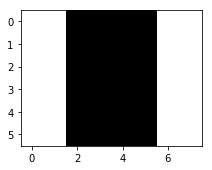

In [3]:
X = nd.ones((6, 8))
X[:, 2:6] = 0
gb.set_fig_size(mpl)
plt.imshow(X.asnumpy(), cmap='gray')
plt.show()

In [4]:

K = nd.array([[1, -1]])
K




[[ 1. -1.]]
<NDArray 1x2 @cpu(0)>

In [5]:

Y = corr2d(X, K)
Y




[[ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]]
<NDArray 6x7 @cpu(0)>

In [6]:
class Conv2D(nn.Block):
    def __init__(self, kernel_size, **kwargs):
        super(Conv2D, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=kernel_size)
        self.bias = self.params.get('bias', shape=(1,))

    def forward(self, x):
        return corr2d(x, self.weight.data()) + self.bias.data()

In [7]:
# 构造一个输出通道是 1 的二维卷基层，我们会在后面小节里解释什么是通道。
conv2d = nn.Conv2D(1, kernel_size=(1, 2))
conv2d.initialize()

# 二维卷基层使用 4 维输入输出，格式为（批量大小，通道数，高，宽），这里批量和通道均为 1.
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))

for i in range(10):
    with autograd.record():
        pY = conv2d(X)
        loss = (pY - Y) ** 2
        print('batch %d, loss %.3f' % (i, loss.sum().asscalar()))
    loss.backward()
    conv2d.weight.data()[:] -= 3e-2 * conv2d.weight.grad()

batch 0, loss 12.080
batch 1, loss 4.949
batch 2, loss 2.028
batch 3, loss 0.831
batch 4, loss 0.341
batch 5, loss 0.140
batch 6, loss 0.057
batch 7, loss 0.024
batch 8, loss 0.010
batch 9, loss 0.004


In [8]:
conv2d.weight.data()


[[[[ 0.9895    -0.9873705]]]]
<NDArray 1x1x1x2 @cpu(0)>


- 构造一个X它有水平方向的边缘，如何设计K来检测它？如果是对角方向的边缘呢？
- 试着对我们构造的Conv2D进行自动求导，会有什么样的错误信息？
- 在Conv2D的forward函数里，将corr2d替换成nd.Convolution使得其可以求导。
- 试着将conv2d的核构造成(2, 2)，会学出什么样的结果？
- 如果通过变化输入和核的矩阵来将相关运算表示成一个矩阵乘法。
